In [5]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns


data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data' #데이터 경로

train_data_path = join(data_dir, 'train.csv') #훈련 데이터 파일
test_data_path = join(data_dir, 'test.csv')  #테스트 데이터 파일

train = pd.read_csv(train_data_path) #훈련데이터를 train에 저장
test = pd.read_csv(test_data_path) #테스트데이터를 test에 저장


In [6]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [7]:
test.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


In [9]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int) #date의 데이터를 정수형(int)으로 처리
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [21]:
#y = train['price'] #y에 훈련데이터의 가격정보를 저장
#del train['price'] #훈련데이터의 가격정보 삭제
#위의 작업은 한번만 가능하기에 오류를 피해 주석처리함

print(train.columns) #price가 사라진 것을 확인


,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201412,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,201412,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,201405,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,201504,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,201503,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


In [13]:
del train['id']

print(train.columns) #id가 사라진 것을 확인

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [76]:
#test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)
#test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

#del test['id'] #테스트데이터에서 id 컬럼 삭제

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [22]:
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

<AxesSubplot:xlabel='price', ylabel='Density'>

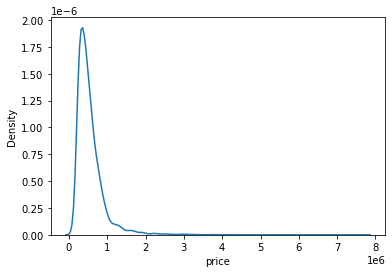

In [25]:
sns.kdeplot(y,shade = False) #그래프화

<AxesSubplot:xlabel='price', ylabel='Density'>

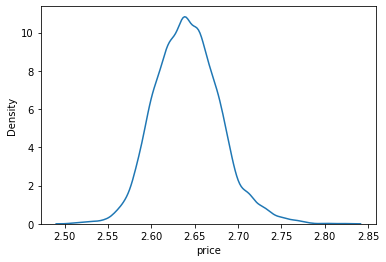

In [27]:
y = np.log1p(y) #log(1+x)
sns.kdeplot(y,shade = False)

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor


def rmse(y_test, y_pred): #모델을 평가하는 함수
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))#np.exm1 (로그를 취했던 값을 되돌리는 함수)


# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다. 
#random_state=None    # 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택합니다.  
random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [29]:
df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df

{'GradientBoostingRegressor': 0.1809232218184817,
 'XGBRegressor': 0.16679809240874063,
 'LGBMRegressor': 0.16314856105233844,
 'RandomForestRegressor': 0.1772598365624751}

In [31]:
#점수를 계산하는 함수 생성
def get_scores(models, train, y):
    df = {}

    for model in models:
        model_name = model.__class__.__name__
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
    return df

get_scores(models, train, y)

{'GradientBoostingRegressor': 0.1809232218184817,
 'XGBRegressor': 0.16679809240874063,
 'LGBMRegressor': 0.16314856105233844,
 'RandomForestRegressor': 0.1772598365624751}

In [32]:
#GridSearch
from sklearn.model_selection import GridSearchCV

param_grid = { #탐색할 파라미터의 종류 type = dic
    'n_estimators' : [50, 100], 
    'max_depth' : [1, 10],
}

model = LGBMRegressor(random_state=random_state) #lightGBM 모델

grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2020), n_jobs=5,
             param_grid={'max_depth': [1, 10], 'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error', verbose=1)

In [47]:
#결과
params = grid_model.cv_results_['params']
score = grid_model.cv_results_['mean_test_score']
print(params)
print(score)

[{'max_depth': 1, 'n_estimators': 50}, {'max_depth': 1, 'n_estimators': 100}, {'max_depth': 10, 'n_estimators': 50}, {'max_depth': 10, 'n_estimators': 100}]
[-0.00036765 -0.00027737 -0.00015077 -0.00014011]


In [50]:
results = pd.DataFrame(params)
results['score'] = score
results['RMSE'] = np.sqrt(-1 * results['score'])

results

,max_depth,n_estimators,score,RMSE
0,1,50,-0.000368,0.019174
1,1,100,-0.000277,0.016655
2,10,50,-0.000151,0.012279
3,10,100,-0.000140,0.011837


In [51]:
results = results.rename(columns={'RMSE': 'RMSLE'})
results

,max_depth,n_estimators,score,RMSLE
0,1,50,-0.000368,0.019174
1,1,100,-0.000277,0.016655
2,10,50,-0.000151,0.012279
3,10,100,-0.000140,0.011837


In [58]:
sort_results = results.sort_values('RMSLE')#정렬
sort_results

,max_depth,n_estimators,score,RMSLE
3,10,100,-0.000140,0.011837
2,10,50,-0.000151,0.012279
1,1,100,-0.000277,0.016655
0,1,50,-0.000368,0.019174


In [59]:
def my_GridSearch(model, train , y, param_grid, verbose = 2, n_jobs = 5):
    model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=verbose, n_jobs=n_jobs)
    model.fit(train, y)
    params = model.cv_results_['params']
    score = model.cv_results_['mean_test_score']
    results = pd.DataFrame(params)
    results['score'] = score
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    return results

my_GridSearch(model, train, y, param_grid)#가장 좋은 점수를 받은 파라미터는 max_depth = 10 , n_estimators = 100 이다.

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
0,1,50,-0.000368,0.019174
1,1,100,-0.000277,0.016655
2,10,50,-0.000151,0.012279
3,10,100,-0.000140,0.011837


[CV] END .......................max_depth=1, n_estimators=50; total time=   0.1s
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[CV] END .....................max_depth=10, n_estimators=100; total time=   0.6s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.2s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.2s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.2s
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[CV] END ......................max_depth=10, n_estimators=50; total time=   0.4s
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[CV] END ......................max_depth=10, n_estimators=50; total time=   0.4s
[LightGBM] [Warning] Accuracy may be bad si

In [61]:
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state) #가장 좋은 점수를 받은 파라미터를 넣고 모델을 돌린다.
model.fit(train, y)
prediction = model.predict(test)
prediction 

array([2.64364262, 2.64014739, 2.71797999, ..., 2.6413381 , 2.61577285,
       2.63572556])

[CV] END .......................max_depth=1, n_estimators=50; total time=   0.1s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.2s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.2s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.2s
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[CV] END ......................max_depth=10, n_estimators=50; total time=   0.4s
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[CV] END .....................max_depth=10, n_estimators=100; total time=   0.6s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.2s
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[CV] END ......................max_depth=10

In [65]:
prediction = np.expm1(prediction)
prediction

array([ 471813.63325142,  449219.53285853, 1396791.07903665, ...,
        456783.58582585,  320545.66580721,  422282.80017931])

In [66]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [67]:
submission['price'] = prediction
submission.head()

,id,price
0,15035,4.718136e+05
1,15036,4.492195e+05
2,15037,1.396791e+06
3,15038,3.191239e+05
4,15039,3.292336e+05


In [68]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.164399')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.164399.csv


In [71]:
#함수화
def save_submission(model, train, y, test, model_name, rmsle):
    model.fit(train, y) #모델 학습
    prediction = model.predict(test) #데이터 예측
    prediction = np.expm1(prediction) #지수 변환
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data' #데이터 저장경로
    submission_path = join(data_dir, 'sample_submission.csv') #결과 경로
    submission = pd.read_csv(submission_path) #경로 읽기
    submission['price'] = prediction # 예측치 (price) 추가
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle) #~~이름으로 저장
    submission.to_csv(submission_csv_path, index=False)#저장
    
save_submission(model, train, y, test, 'lgbm', rmsle='0.0168')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
